# Quantum chemistry on the QLM

The **Variational Quantum Eigensolver** method solves the following minimization problem :
$$
E = \min_{\vec{\theta}}\; \langle \psi(\vec{\theta}) \,|\, \hat{H} \,|\, \psi(\vec{\theta}) \rangle
$$

Here, we use a **Unitary Coupled Cluster** trial state, of the form:
$$
|\psi(\vec{\theta})\rangle = e^{\hat{T}(\vec{\theta}) - \hat{T}^\dagger(\vec{\theta})} |0\rangle
$$
where $\hat{T}(\theta)$ is the *cluster operator*: 
$$
\hat{T}(\vec{\theta}) = \hat{T}_1(\vec{\theta}) + \hat{T}_2(\vec{\theta}) + \cdots
$$
where
$$
\hat{T}_1 = \sum_{a\in U}\sum_{i \in O} \theta_a^i\, \hat{a}_a^\dagger \hat{a}_i \qquad
\hat{T}_2 = \sum_{a>b\in U}\sum_{i>j\in O} \theta_{a, b}^{i, j}\, \hat{a}^\dagger_a \hat{a}^\dagger_b \hat{a}_i \hat{a}_j \qquad
\cdots
$$
($O$ is the set of occupied orbitals and $U$, the set of unoccupied ones.)

## Example: $H_2$ molecule

One has to first describe the geometry and atomic content of the molecule (in this case, $H_2$).

This is done, in the cell below, using the open-source ``pySCF`` package. We specify the chosen basis set and the studied geometry. Here, we chose to study dihydrogen in the so-called STO-3G basis at 1.75 Angström (internuclear distance.)

In [1]:
import numpy as np

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation


geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis = "sto-3g"
spin = 0  # = 2 S with S total spin angular momentum = # of unpaired electrons
charge = 0


"""Other examples:

# LiH
geometry = [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.75))]
basis = "6-31g"
spin = 0
charge = 0

# CO2
geometry = [['C', [0.0, 0.0, 8.261342997000753e-07]],
            ['O', [1.0990287608769004e-18, 2.7114450405987004e-19, 1.2236575813458745]],
            ['O', [2.696319376811295e-22, 2.4247676462727696e-23, -1.2236561920609494]]]
basis = "sto-3g"
spin = 1
charge = 1
"""

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, verbose=True)

# rdm1 = (rdm1[0] + rdm1[1]) / 2. # For CO2
print("Number of qubits before active space selection = ", rdm1.shape[0] * 2)

/usr/local/lib64/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


HF energy= -1.1166843870853405
MP2 energy= -1.1298551535553094
FCI energy= -1.137270174660903
Number of qubits before active space selection =  4


## Wrap the body integrals and the nuclear repulsion in the `MolecularHamiltonian` classes.

In [2]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

print(mol_h)

 MolecularHamiltonian(
 - constant_coeff : 0.7137539936876182
 - integrals shape
    * one_body_integrals : (2, 2)
    * two_body_integrals : (2, 2, 2, 2)



## Active space selection

Based on the (approximate) one-particle reduced density matrix computed (``rdm1``), we compute the so-called "natural-orbital occupation numbers" (NOONs). We use them to select, with a given threshold, the "active space orbitals" (which are contained in the ``active_indices`` list below). We then compute the Hamiltonian in this active space.

In [3]:
# Compute the natural orbitals occupation numbers and the basis transformation matrix
noons, basis_change = np.linalg.eigh(rdm1)

# The noons should be in decreasing order
noons = list(reversed(noons))

# Since we reversed the noons, we have to flip the basis as well
basis_change = np.flip(basis_change, axis=1)

### The basis change can be done within the `MolecularHamiltonian` class.

In [4]:
# Change the hamiltonian basis
mol_h_new_basis = mol_h.transform_basis(basis_change)

### The active space selection can also be done within the `MoleculeInfo` class.

In [5]:
molecule = MoleculeInfo(
    mol_h_new_basis,
    n_electrons=n_electrons,
    noons=noons,
    orbital_energies=orbital_energies,
)

In [6]:
molecule

MoleculeInfo(
 - MolecularHamiltonian(
    * constant_coeff : 0.7137539936876182
    * integrals shape
       ** one_body_integrals : (2, 2)
       ** two_body_integrals : (2, 2, 2, 2)
 - n_electrons = 2
 - noons = [1.9745399697399246, 0.025460030260075383]
 - orbital energies = [-0.57797481  0.66969867]
)

## Computation of cluster operators $T$ and good guess $\vec{\theta}_0$

We now construct the cluster operators (``cluster_ops``) defined in the introduction part as $\hat{T}(\vec{\theta})$, as well as a good starting parameter $\vec{\theta}$ (based on MP2 theory).

In [7]:
from qat.fermion.chemistry.ucc import guess_init_params, get_hf_ket, get_cluster_ops

# Computation of the initial  parameters
theta_list = guess_init_params(
    molecule.two_body_integrals,
    molecule.n_electrons,
    molecule.orbital_energies,
)

print(f"List of initial parameters : {theta_list}")

List of initial parameters : [0, 0, 0.07265074220469023]


In [8]:
# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(molecule.n_electrons, molecule.nqbits)
print(f"Initial Hartree-Fock state : {ket_hf_init}")

Initial Hartree-Fock state : 12


In [9]:
# Compute the cluster operators
cluster_ops = get_cluster_ops(molecule.n_electrons, nqbits=molecule.nqbits)

## Encode to qubits: Fermion-spin transformation

All the above operators are fermion operators. We now transform them to spin (or qubit) space. There are different possible choices. Here, we choose the Jordan-Wigner transform (the commented out imports show how to use the other transforms that are available on QLM).

In [10]:
from qat.fermion.transforms import transform_to_jw_basis

# Compute the ElectronicStructureHamiltonian
H_active = molecule.hamiltonian.get_electronic_hamiltonian()

# Transform the ElectronicStructureHamiltonian into a spin Hamiltonian
H_active_sp = transform_to_jw_basis(H_active)

print(H_active_sp.htype)

ObservableType.SPIN


In [11]:
from qat.fermion.transforms import recode_integer, get_jw_code

# Express the cluster operator in spin terms
cluster_ops_sp = [transform_to_jw_basis(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, get_jw_code(H_active_sp.nbqbits))

## Trotterize the Hamiltonian to get the parameterized circuit to optimize

In [12]:
from qat.lang.AQASM import Program, X
from qat.fermion.trotterisation import make_trotterisation_routine

nqbits = cluster_ops_sp[0].nbqbits

prog = Program()
reg = prog.qalloc(nqbits)

# Initialize the Hartree-Fock state into the Program
for j, char in enumerate(format(hf_init_sp, "0" + str(nqbits) + "b")):
    if char == "1":
        prog.apply(X, reg[j])

# Define the parameters to optimize
theta = [prog.new_var(float, "\\theta_{%s}" % i) for i in range(len(cluster_ops))]

# Define the parameterized Hamiltonian
hamiltonian = sum([th * T for th, T in zip(theta, cluster_ops_sp)])

# Trotterize the Hamiltonian (with 1 trotter step)
qrout = make_trotterisation_routine(hamiltonian, n_trotter_steps=1, final_time=1)

prog.apply(qrout, reg)
circ = prog.to_circ()

In [13]:
# Alternatively, you can simply use the `construct_ucc_ansatz` fonction

from qat.fermion.chemistry.ucc import construct_ucc_ansatz

prog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp, n_steps=1)
circ = prog.to_circ()

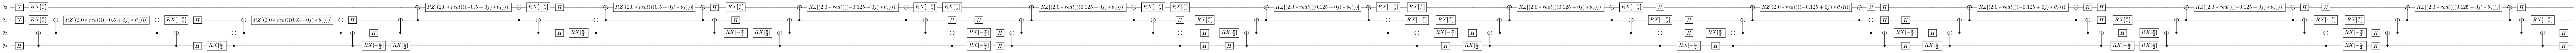

In [14]:
circ.display()

## Optimize the angles of $\psi(\vec{\theta})$ for a given QPU

We can now use the QLM's variational plugins to perform the VQE optimization.

In [15]:
job = circ.to_job(job_type="OBS", observable=H_active_sp, nbshots=0)

from qat.qpus import LinAlg
from qat.vsolve.optimize import ScipyMinimizePlugin

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000}, x0=theta_list)
qpu = optimizer_scipy | LinAlg()
result = qpu.submit(job)

print("Minimum energy =", result.value)
print("FCI energy:", info["FCI"])

Minimum energy = -1.1372692374939386
FCI energy: -1.137270174660903


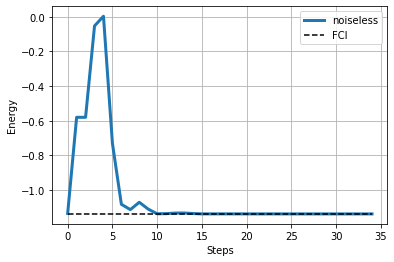

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## With a Noisy QPU

We can easily switch to another QPU. Here, we want to investigate the effect of noise on VQE accuracy.
To this end, we use a noisy QPU with a simple noise model with $T_1$ and $T_2$ noise.

In [17]:
from qat.hardware import HardwareModel, DefaultGatesSpecification
from qat.quops import ParametricAmplitudeDamping, ParametricPureDephasing
from qat.qpus import NoisyQProc
from qat.plugins import StatPlugin

gate_durations = {
    "Z": 60,
    "H": 60,
    "X": 60,
    "Y": 60,
    "RX": lambda angle: 60,
    "RY": lambda angle: 60,
    "RZ": lambda angle: 60,
    "CNOT": 150,
}  # nanosecs
T1 = 50000  # = 50 microsecs
T2 = 50000

amp_damping = ParametricAmplitudeDamping(T_1=T1)
pure_dephasing = ParametricPureDephasing(T_phi=1 / (1 / T2 - 1 / (2 * T1)))
hw_model = HardwareModel(DefaultGatesSpecification(gate_durations), idle_noise=[amp_damping, pure_dephasing])
noisy_qpu = NoisyQProc(hardware_model=hw_model, sim_method="deterministic-vectorized")


qpu = StatPlugin() | optimizer_scipy | noisy_qpu
result_n = qpu.submit(job)
print("Minimum energy =", result_n.value)

=== StatPlugin:compile ===
Job 0: {'nbqbits': 4, 'size': 158, 'gates': {'custom gate': 0, 'X': 2, 'RX': 40, 'H': 40, 'CNOT': 64, 'RZ': 12}, 'measurements': 0, 'resets': 0, 'logic': 0, 'breaks': 0, 'remaps': 0, 'gate_size': 158}
Minimum energy = -0.937772457791241


## Comparison: noiseless vs. noisy

As you can see, the final energy obtained with a noisy QPU is higher than the one obtained with a perfect (noiseless) QPU:

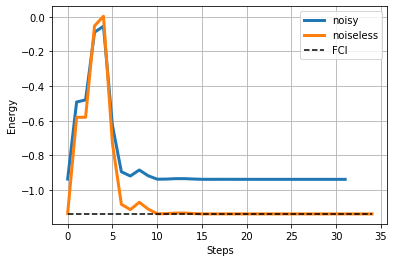

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result_n.meta_data["optimization_trace"]), label="noisy", lw=3)
plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## VQE with noise + constraints:

We now add another layer of complexity by adding connectivity constraints to the QPU. This is done via the ``QuameleonPlugin``. As a result of these constraints, the circuit needs to be compiled. This task is carried out by yet another QLM plugin, the ``Nnizer`` (see also the ``LazySynthesis`` plugin that carries out a similar task). Notice how the gate count (printed through the ``StatPlugin`` plugin) has increased with respect to the original circuit:

In [19]:
import json
from qat.core import Topology, HardwareSpecs, TopologyType
from qat.plugins import Nnizer, QuameleonPlugin, Remap

graph_dict = json.load(open("graph_ibmqx5.json", "r"))["edges"]  # we load a graph (here corresponding to IBM QX5' chip)
graph = {int(vertex): edges for vertex, edges in graph_dict.items()}
topology = Topology(type=TopologyType.CUSTOM, is_directed=False, graph=graph)
hw_specs = HardwareSpecs(nbqbits=16, topology=topology)
nnizer = Nnizer()

# the Remap plugin below allows for a smart remapping of qubits to minimize the qubit count
noisy_qpu_with_topology = QuameleonPlugin(specs=hw_specs) | (Remap() | noisy_qpu)
qpu = Nnizer() | StatPlugin() | optimizer_scipy | noisy_qpu_with_topology
result_nn = qpu.submit(job)
print("Minimum energy =", result_nn.value)

=== StatPlugin:compile ===
Job 0: {'nbqbits': 16, 'size': 503, 'gates': {'custom gate': 0, 'X': 2, 'RX': 40, 'H': 328, 'CNOT': 121, 'RZ': 12}, 'measurements': 0, 'resets': 0, 'logic': 0, 'breaks': 0, 'remaps': 0, 'gate_size': 503}
Minimum energy = -0.7027404505350231


## Final comparison

Below, we compare the convergence of the VQE energy for the different QPUs. As expected, in the presence of noise and connectivity constraints, the VQE energy is highest because connectivity constraints lead to longer circuits that in turn lead to a higher sensitivity to decoherence.

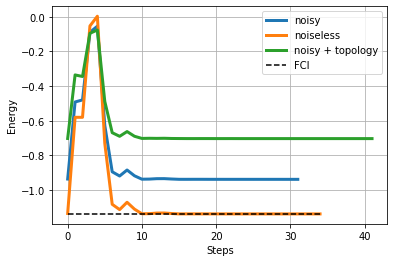

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result_n.meta_data["optimization_trace"]), label="noisy", lw=3)
plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(eval(result_nn.meta_data["optimization_trace"]), label="noisy + topology", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## Further questions to be investigated:

This notebook only tackles certain aspects of performing chemistry on the QLM with advanced QPUs and Plugins. Other questions that you can deal with using other QLM tools include:

- how to reduce the gate count given a topology?
- how to rewrite a circuit for another gate set (say, for ions)?
- how to mitigate noise effects? (zero-noise extrapolation...)